# Project: Wrangling and Analyze Data

## Data Gathering
First we import all necessary Python modules and libraries...

In [1]:
# importing useful modules
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import requests
from zipfile import ZipFile # for backing up the relevant files

% matplotlib inline

Next we will load the necessary data for this project. In order, these are...
- The WeRateDogs Enhanced Twitter Archive "twitter-archive-enhanced.csv" for basic tweet information.
This will contain the basic information for our analysis.
- The Image Prediction Library. 
- Data from the twitter API.

### Downloading the WeRateDogs Enhanced Twitter Archive

In [2]:
# downloading the WeRateDogs Twitter archive data.
df_twitenh = pd.read_csv("twitter-archive-enhanced.csv")

### Downloading the Image Predictions Library
We'll use the Requests library to download the tweet image prediction file, then convert it to a pandas dataframe object (image_predictions.tsv).

In [3]:
# downloading the image prediction library programmatically
imgurl = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
img_pre = requests.get(imgurl)

In [4]:
# creating a dataframe from the image predictions
with open("image_predictions.tsv", "wb") as file:
    file.write(img_pre.content)

df_imgpre = pd.read_csv("image_predictions.tsv", sep="\t")

### Downloading the additional tweet data
Here, I used the tweet-json.txt file provided by Udacity.
We'll read the file then construct a pandas DataFrame object from it.

In [5]:
# reading tweet_json.txt
with open("tweet-json.txt") as file:
    tweet_json = tuple(file.readlines()) # I've been told tuples are faster to search

In [6]:
# create a dataframe object from tweet_json
dcts = []
for line in tweet_json:
    dcts.append(json.loads(line))
df_twitxtra = pd.DataFrame(dcts)

We'll have to modify this dataframe if we want to use it. We'll select only the "id", "id_str", "retweet_count", "favorite_count", "retweeted_status" and "quoted_status" columns.
- The "id" column is the unique id of the tweet as an integer.
- The "id_str" column is the id represented as a string. According to [this post](https://developer.twitter.com/en/docs/twitter-api/v1/data-dictionary/object-model/tweet), it's safer to use the id_str than the id so we'll keep it just for further assessment.
- The "retweet_count" counts the number of retweets that the given tweet in question got.
- The "favorite_count" counts the number of likes that the given tweet got.
- The "retweeted_status" attribute only appears if the given tweet object is a retweet of something else. If the given tweet is not a retweet, the attribute is NaN. Otherwise, the value of the attribute is a representation of the original tweet i.e. the "parent", the one that was retweeted.
- The "quoted_status" attribute only appears if the given tweet object is a quote tweet. Otherwise it is null.

It's important to note that a tweet can't be both a retweet and a quote tweet.
The aforementioned columns will be enough to help us with subsequent analyses.

In [7]:
# select only what we want
cols = ("id", "id_str", "retweet_count", "favorite_count", "retweeted_status", "quoted_status")
df_twitxtra = df_twitxtra.loc[:,cols].copy()

## Assessing Data
We'll inspect the Enhanced Twitter Archive, Extra Tweet information and Image Predictions dataframes in order. It first helps to get a very broad, bird's eye overview of the dataframes. We'll first check if all three dataframes have the same number of rows. If they don't, this suggests missing values.

In [8]:
# check if all three tables have the same number of rows
condition = (df_twitenh.shape[0] == df_twitxtra.shape[0]) == df_imgpre.shape[0]
if condition:
    print("The tables have the same number of rows.")
    print(df_twitenh.shape[0], "rows.") # since they'll have the same number of rows.
elif not condition:
    print("The tables don't have the same number of rows.")
    print("Enhanced Twitter Archive has", df_twitenh.shape[0], "rows")
    print("Extra Twitter Archive has", df_twitxtra.shape[0], "rows")
    print("Image Prediction Dataframe has", df_imgpre.shape[0], "rows")

The tables don't have the same number of rows.
Enhanced Twitter Archive has 2356 rows
Extra Twitter Archive has 2354 rows
Image Prediction Dataframe has 2075 rows


Because the Enhanced Twitter Archive and Extra Twitter Archive (tweet-json) don't have the name number of rows, there are likely values missing from the Extra Twitter Archive.
If we're lucky, the discrepancy could be due to one table having duplicate values (hence both have the same set of rows but one duplicates some rows).
If we're not so lucky, then the Enhanced Twitter Archive simply has more information than the Extra Twitter/tweet-json table.
The difference isn't much but it's worth pointing out.

Another issue is that the Image Predictions table has far fewer rows than the other two.
If we're lucky then perhaps all tables have the same set of rows but the difference in number is due to duplication.
If we're not lucky then there are rows which the Image Predictions dataframe/table lacks, which is a missing-values problem.

The next step is to examine the columns.

In [9]:
# what columns does the enhanced archive have?
df_twitenh.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo'],
      dtype='object')

It seems there are too many columns in the Enhanced Twitter Archive - all the dog stages "doggo", "floofer", etc. should be in a single column.

In [10]:
# what columns does the extra tweet info dataframe have?
df_twitxtra.columns

Index(['id', 'id_str', 'retweet_count', 'favorite_count', 'retweeted_status',
       'quoted_status'],
      dtype='object')

By design, the Extra Twitter dataframe contains exactly what we need. However, the fact that the information is in a table separate from other tweet metadata suggests a structural issue.

Next, we take an overview of the image-predictions dataframe.

In [11]:
# what columns are in the image predictions table?
df_imgpre.columns

Index(['tweet_id', 'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2',
       'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'],
      dtype='object')

Just like before, the (important) information provided here shouldn't be in a separate table. We could use fewer tables overall.

Let's now find out a bit more about each column in the dataframes - number of rows, types, etc.

In [12]:
# an overview of the extra twitter information
df_twitenh.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

The first issue noticed is that the timestamp is not a dtime object but a string object.

Next, the dataset contains retweets. The reason is because the "retweeted_status_id" column has 181 non-null values, which means 181 retweets.
It also contains tweets that are replies, as indicated by the non-null "in_reply_to_status_id" and "in_reply_to_user_id" values.

Earlier we saw that the three dataframes didn't have the same number of rows.
Even so, we hoped that they all had the same set of data and the discrepancy was due to some tables having duplicate rows. Let's see if there are any duplicate rows present.

In [13]:
# How many duplicated rows are there?
print("There are", sum(df_twitenh.duplicated()), "duplicates here.")

There are 0 duplicates here.


Now we're sure that the discrepancy is due to the smaller tables having missing values.
Now let's assess the Extra Twitter/tweet-json dataframe.

In [14]:
# birds eye view
df_twitxtra.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 6 columns):
id                  2354 non-null int64
id_str              2354 non-null object
retweet_count       2354 non-null int64
favorite_count      2354 non-null int64
retweeted_status    179 non-null object
quoted_status       28 non-null object
dtypes: int64(3), object(3)
memory usage: 110.4+ KB


From this overview, the above dataset seems fairly clean. There are no missing values in any of the columns except for retweeted_status and quoted_status but that's not a problem since the missing values in that case are meaningful. It just means that the tweet in question is not a retweet, or quote tweet respectively.

This means that the table has exactly 179 tweets that are retweets. This is different from the number of retweets in the Enhanced Twitter Archive, suggesting even more discrepancy between the dataframes. It also has 28 quote tweets present.

Let's count the number of duplicated rows.

In [15]:
# how many duplicated rows are there?
dpl = sum(df_twitxtra.loc[:,"id":"favorite_count"].duplicated())
print("There are", dpl, "duplicates here.")

There are 0 duplicates here.


There are no duplicated rows here, meaning that any discrepancy in the number of rows between the tables is due to missing values in the smaller tables.

However, this assessment doesn't check another form of duplication, which is retweets. Even retweets have unique ID's, so simply comparing rows won't tell us if one row is a retweet or not.

The next thing is to see if the id and id_str columns match.

In [16]:
# zip the relevant columns
# this creates something similar to a 'list' of tuples of the form (id,id_str)
z = zip(df_twitxtra['id'], pd.to_numeric(df_twitxtra['id_str']))

In [17]:
# do they match?
passed = True
for pair in tuple(z):
    tweet_id = pair[0]
    tweet_idstr = pair[1]
    if tweet_id!=tweet_idstr:
        print(f"Test failed, id {tweet_id} doesn't match id_str {tweet_idstr}.")
        passed = False
        break
if passed:
    print("Test passed. All ids match id string.")

Test passed. All ids match id string.


Finally, let's look at the image predictions dataframe.

In [18]:
# what's the image-predictions table like?
df_imgpre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


That one seems to be complete. There are 2075 rows and each column has 2075 non-null observations. But are some rows duplicates?

In [19]:
# how many duplicates in the image-predictions table?
print("There are", sum(df_imgpre.duplicated()), "duplicates here.")

There are 0 duplicates here.


That seems to be the cleanest table we have, although it's too early to judge.
Let's see if the tweet ID's are unique...

In [20]:
# just to see if all tweet ids are unique. Move this to assessment stage.
if len(df_imgpre['tweet_id'].unique())==df_imgpre.shape[0]:
    print("Tweet ID's are unique.")

Tweet ID's are unique.


Now, let's get a closer visual overview of each dataframe. We'll inspect ten random rows from each, to get a sense of how the data is structured. This may clutter the notebook, but it's a reasonable number.

#### Assessing the Enhanced Twitter Archive dataframe in detail...

In [21]:
# explore randomly
df_twitenh.sample(10, random_state=7)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
194,855245323840757760,NaN,NaN,2017-04-21 02:22:29 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet George. He looks slightly ...,8.421635e+17,4.196984e+09,2017-03-16 00:00:07 +0000,https://twitter.com/dog_rates/status/842163532...,12,10,George,None,None,None,None
34,885528943205470208,NaN,NaN,2017-07-13 15:58:47 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Maisey. She fell asleep mid-excavation...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/885528943...,13,10,Maisey,None,None,None,None
927,754856583969079297,NaN,NaN,2016-07-18 01:53:28 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Winnie. She's not a fan of the fast mo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/754856583...,11,10,Winnie,None,None,None,None
660,791312159183634433,NaN,NaN,2016-10-26 16:14:55 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Mabel. She's super h*ckin smol. Portab...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/791312159...,12,10,Mabel,None,None,None,None
1354,703631701117943808,NaN,NaN,2016-02-27 17:24:05 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bella. Based on this picture she's at ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/703631701...,11,10,Bella,None,None,None,None
1695,681261549936340994,NaN,NaN,2015-12-27 23:53:05 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Panda. He's a Quackadilly Shooste...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/681261549...,9,10,Panda,None,None,None,None
1005,747651430853525504,7.476487e+17,4.196984e+09,2016-06-28 04:42:46 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Other pupper asked not to have his identity sh...,NaN,NaN,NaN,NaN,12,10,None,None,None,pupper,None
1077,739544079319588864,NaN,NaN,2016-06-05 19:47:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This... is a Tyrannosaurus rex. We only rate d...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/739544079...,10,10,None,None,None,None,None
2323,666428276349472768,NaN,NaN,2015-11-17 01:30:57 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have an Austrian Pulitzer. Collectors ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666428276...,7,10,None,None,None,None,None
464,817415592588222464,NaN,NaN,2017-01-06 17:00:38 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Strudel. He's rather h*ckin pupset that y...,NaN,NaN,NaN,https://www.gofundme.com/help-strudel-walk-aga...,11,10,Strudel,None,None,None,None


This random sampling tells us that some dogs are un-named. The name column shows "None", and it's unlikely there are many dogs named "None". While we don't plan on doing analysis with the dog names, it would still have been nice to have a name for each dog. 

Let's visually inspect the unique dog names present.

In [22]:
# which dog names do we have?
df_twitenh["name"].unique()

array(['Phineas', 'Tilly', 'Archie', 'Darla', 'Franklin', 'None', 'Jax',
       'Zoey', 'Cassie', 'Koda', 'Bruno', 'Ted', 'Stuart', 'Oliver', 'Jim',
       'Zeke', 'Ralphus', 'Canela', 'Gerald', 'Jeffrey', 'such', 'Maya',
       'Mingus', 'Derek', 'Roscoe', 'Waffles', 'Jimbo', 'Maisey', 'Lilly',
       'Earl', 'Lola', 'Kevin', 'Yogi', 'Noah', 'Bella', 'Grizzwald',
       'Rusty', 'Gus', 'Stanley', 'Alfy', 'Koko', 'Rey', 'Gary', 'a',
       'Elliot', 'Louis', 'Jesse', 'Romeo', 'Bailey', 'Duddles', 'Jack',
       'Emmy', 'Steven', 'Beau', 'Snoopy', 'Shadow', 'Terrance', 'Aja',
       'Penny', 'Dante', 'Nelly', 'Ginger', 'Benedict', 'Venti', 'Goose',
       'Nugget', 'Cash', 'Coco', 'Jed', 'Sebastian', 'Walter', 'Sierra',
       'Monkey', 'Harry', 'Kody', 'Lassie', 'Rover', 'Napolean', 'Dawn',
       'Boomer', 'Cody', 'Rumble', 'Clifford', 'quite', 'Dewey', 'Scout',
       'Gizmo', 'Cooper', 'Harold', 'Shikha', 'Jamesy', 'Lili', 'Sammy',
       'Meatball', 'Paisley', 'Albus', 'Neptune', '

From skimming the list there are quite a few unusual dog names - 'a', 'an', 'O', 'my', 'officially', 'by', 'this', 'all', etc.
There's no philosophical reason why these can't be valid dog names, but for practical purposes it seems more likely to be a cleanliness issue.
Going through the list manually for these unusual dog names will be tedious so instead we'll take a leap of faith and assume that most of these faulty names...
- are "None"
- begin with lowercase
- are fewer than three characters long.

We'll explore these tests in more detail during the cleaning stage but for now let's hope that most of the invalid names satisfy this criteria, and most names that satisfy this criteria are invalid.

In [23]:
# look for unusual names
def get_strange_names(names_list):
    strange_names = []
    for name in names_list:
        condition = (name.lower()=="none") or (len(name)<=2) or (name[0]==name.lower()[0])
        if condition:
            strange_names.append(name)
    return strange_names

In [24]:
# visually inspect the strange names
print(get_strange_names(df_twitenh['name'].unique()))

['None', 'such', 'a', 'quite', 'not', 'one', 'Mo', 'Bo', 'incredibly', 'mad', 'an', 'very', 'O', 'Al', 'just', 'my', 'his', 'actually', 'getting', 'this', 'unacceptable', 'all', 'old', 'infuriating', 'the', 'by', 'officially', 'life', 'Ed', 'light', 'space', 'JD', 'Jo']


Most of the names here pass our test for what constitutes a strange name.
The test isn't perfect - it could miss a title-case name such as "Unacceptable", but if the name is in title case then that's probably the dog's actual name. During the cleaning stage we'll make use of this test again, making sure to manually filter out the more legitimate-looking names.

The next thing to notice is that each of the columns pupper, puppo, doggo and floofer seem to be sparse in terms of values. Most of the values in these are null (represented by the string "None"). It looks like these are meant to indicate "False" (i.e. "None" means "This dog is not a pupper"), but let's test that hypothesis by checking the unique values for each column.

In [25]:
# check the unique values for the columns
cols = ('pupper','puppo','doggo','floofer')
for col in cols:
    print(col, 'has unique values', df_twitenh[col].unique())

pupper has unique values ['None' 'pupper']
puppo has unique values ['None' 'puppo']
doggo has unique values ['None' 'doggo']
floofer has unique values ['None' 'floofer']


If we replace "None" with "False", the data still makes sense, so let's assume that "None" means "False". It's also good that the unique values correspond to the column names (for example it would be strange if the column "doggo" had anything other than None, or True, or doggo).

But the random selection of columns reveals a problem with the dataset - there are rows without any dog_stage information (i.e. each column "pupper", "puppo", etc. contains None). Just how many of these are there? Are there rows that classify a dog in several different stages at once? We'll have to assess these issues with the assumption that no dog can exist in multiple dog stages at once.

The plan is to use a smaller dataframe consisting of only the columns we want to test - doggo, floofer, pupper and puppo as arranged in the original df_twitenh dataframe.
We'll then iterate across each row, testing if there's more than one non-null (i.e. 'None') observation on the same row. We already know that any given observation is any of 'None', 'doggo', 'floofer', 'pupper' or 'puppo' so we don't have to worry about weird misspellings throwing our analysis off.

Once again, what we want to do is to check if on a given row there are more than two unique values - one of which is None and the others any of "pupper", "puppo", "doggo" or "floofer" exclusively.
At the same time, we'll keep count of how many non-Null values we have in total and compare it to the total number of rows in the dataframe.

In [26]:
# create a sub-dataframe
df_dogstages = df_twitenh.loc[:,'doggo':'puppo']

Assessing this sub-dataframe visually would be incredibly tedious so we'll instead do it using a function.

In [27]:
# define a function to test if each row has at most two non-null observations
def is_two_or_fewer(row):
    """expects a tuple or iterable, checks if at most two unique values in tuple/iterable
    """
    seen = []
    for val in row:
        if val not in seen:
            seen.append(val) # append if you haven't seen before
        elif val in seen:
            continue # skip if you've seen before
    nunique = len(seen)
    # is nunique btw 0 and 2 inclusive?
    # 0 means all are truly null i.e NaN
    # 1 means single unique value ("None","pupper", etc)
    # 2 means two unique values on same row.
    # 3 or more is invalid
    return ((0<=nunique)and(nunique<=2))

Before we proceed, it's important to mention that the function defined above doesn't explicitly account for unusual cases such as each row containing "doggo" for all columns e.g ("doggo","doggo","doggo","doggo").

However, we don't have to worry about that because we've seen already that each column only contains the appropriate dog stage or "None". Thus, for this particular dataset, a case like ("doggo","doggo","doggo","doggo") is impossible because that would mean the three other columns contain the wrong dog stage.

The next task is to define a function to count the number of 'populated' rows - rows containing anything other than "None". This will be used together with a counter.

In [28]:
# a function to count how many rows have actually recorded the dog stage.
# returns 1 as soon as a non-null item is encountered.
# if that happens, the last line is never reached.
def has_elements(row):
    """we're returning numbers because we want to use this as part of a running sum"""
    for item in row:
        if (item != 'None'):
            return 1
    return 0

Finally, we need a way to create a list of every row in the dataframe which we can run our tests on. The strategy is to access each row using pandas iloc method and for each row, append the column value to a tuple which will be appended to a list.

In [29]:
# 
def tuplify_rows(dframe):
    """what this returns can be thought of as a table - a 2D list"""
    rows = []
    no_of_rows = dframe.shape[0]
    for i in range(no_of_rows):
        row_as_tuple = tuple(dframe.loc[i,'doggo':'puppo']) # pray the indexing is correct
        rows.append(row_as_tuple)
    return tuple(rows) # i heard tuples are faster to search

In [30]:
# Convert the df_dogstages dataframe to a tuple of each row...
tup_dogstages = tuplify_rows(df_dogstages)
# print the first few rows
for i in range(5):
    print(tup_dogstages[i])

('None', 'None', 'None', 'None')
('None', 'None', 'None', 'None')
('None', 'None', 'None', 'None')
('None', 'None', 'None', 'None')
('None', 'None', 'None', 'None')


Now, we can run our tests using the tuple of rows.

In [31]:
# running the test
non_nulls = 0 # the number of rows so far which actually have information about the dog stage
conflicted_rows = 0 # counts the number of rows recording more than two unique dog-stages
no_of_rows = len(tup_dogstages) # also same as df_dogstages.shape[0], which is same as in original dataframe

for row in tup_dogstages:
    if not is_two_or_fewer(row): # i.e. has more than 'None' or a single dogstage
        conflicted_rows += 1
    non_nulls += has_elements(row)


Now, let's see what we got...

In [32]:
# print results
message1 = f"There are {conflicted_rows} rows with multiple dog stages"
message2 = f"There are {non_nulls} non-null rows, which is about {int(100*(non_nulls/no_of_rows))} percent of rows."
print(message1)
print(message2)

There are 14 rows with multiple dog stages
There are 380 non-null rows, which is about 16 percent of rows.


There are very few rows with multiple dog stages. We'll look at those soon, but more significant is the fact that only a small proportion of rows in our dataset actually have any information about the dog stage which isn't very encouraging. We may still be able to use it for analysis later, but it won't be as powerful compared to having more rows to use.

Let's see which rows have multiple dog stages.

In [33]:
# gather the rows with multiple dog stages
conflicted_rows_ind = []
for ind,row in enumerate(tup_dogstages):
    if not is_two_or_fewer(row):
        conflicted_rows_ind.append(ind)

# let's examine them
for ind in conflicted_rows_ind:
    print('row', ind, '-->', tuple(df_dogstages.iloc[ind,:]))

row 191 --> ('doggo', 'None', 'None', 'puppo')
row 200 --> ('doggo', 'floofer', 'None', 'None')
row 460 --> ('doggo', 'None', 'pupper', 'None')
row 531 --> ('doggo', 'None', 'pupper', 'None')
row 565 --> ('doggo', 'None', 'pupper', 'None')
row 575 --> ('doggo', 'None', 'pupper', 'None')
row 705 --> ('doggo', 'None', 'pupper', 'None')
row 733 --> ('doggo', 'None', 'pupper', 'None')
row 778 --> ('doggo', 'None', 'pupper', 'None')
row 822 --> ('doggo', 'None', 'pupper', 'None')
row 889 --> ('doggo', 'None', 'pupper', 'None')
row 956 --> ('doggo', 'None', 'pupper', 'None')
row 1063 --> ('doggo', 'None', 'pupper', 'None')
row 1113 --> ('doggo', 'None', 'pupper', 'None')


After consulting the [dog slang dictionary](https://video.udacity-data.com/topher/2017/October/59e04ceb_dogtionary-combined/dogtionary-combined.png) for these terms, it seems that a dog can exist in multiple dog stages if we play loose and fast with terms. However, the analysis I'm going for is mostly concerned with the size of the dog.
- "Pupper" means small dog, or puppy
- "Doggo" means large dog
- "Puppo" is intermediate size
- "Floofer" relates more to furriness than to size

A dog can be a Floofer and anything else, but the rest seem to suggest the existence of dogs that are both big and small, which is contradictory. These rows seem to dirty up the dataset.
Because these rows are few in number let's examine the corresponding tweets in close detail to get an idea of what is happening.

In [34]:
# examine the tweets that have multiple dog stages
for i in df_twitenh.index:
    row = df_twitenh.loc[i,'doggo':'puppo']
    if not is_two_or_fewer(row):
        print(i, tuple(row), df_twitenh.loc[i,'text'])
        print(100*'_')

191 ('doggo', 'None', 'None', 'puppo') Here's a puppo participating in the #ScienceMarch. Cleverly disguising her own doggo agenda. 13/10 would keep the planet habitable for https://t.co/cMhq16isel
____________________________________________________________________________________________________
200 ('doggo', 'floofer', 'None', 'None') At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send dogs https://t.co/TXdT3tmuYk
____________________________________________________________________________________________________
460 ('doggo', 'None', 'pupper', 'None') This is Dido. She's playing the lead role in "Pupper Stops to Catch Snow Before Resuming Shadow Box with Dried Apple." 13/10 (IG: didodoggo) https://t.co/m7isZrOBX7
____________________________________________________________________________________________________
531 ('doggo', 'None', 'pupper', 'None') Here we have Burke (pupper) and Dexter (doggo). 

Upon manual assessment, most of these offending tweets are actually ratings for multiple dogs in the same tweet. A few of them are fairly clean and will be corrected in the cleaning stage.

The next step is to do a statistical summary of the dataframe.

In [35]:
# statistical summary
df_twitenh.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


At first everything seems fine until you notice the rating_denominator column.
The mean is 10.455433. This should be impossible if that column is uniform i.e. every value in that column is 10. Also, the maximum is 170.000000, which is obviously not 10.

A lot of emphasis was placed on the fact that the rating denominators are always 10, so this is a data cleanliness issue. Let's check just how many rows contain the wrong denominator value.

In [36]:
# create a series object...
denoms = df_twitenh["rating_denominator"]

# how many rows have denominators other than 10?
bad_ratings_count = 0
bad_ratings_rows = []
for ind,val in enumerate(denoms):
    if val != 10:
        bad_ratings_count += 1
        bad_ratings_rows.append(ind)

# print the amount
print("There are", bad_ratings_count, "ratings with denominators other than 10.")
print("These are from rows...", "\n", bad_ratings_rows)

There are 23 ratings with denominators other than 10.
These are from rows... 
 [313, 342, 433, 516, 784, 902, 1068, 1120, 1165, 1202, 1228, 1254, 1274, 1351, 1433, 1598, 1634, 1635, 1662, 1663, 1779, 1843, 2335]


Thankfully it doesn't seem like there are too many of these rows.

#### Assessing the Twitter API dataframe in detail...

Also referred to as the Extra Twitter Information dataset - the one we constructed from tweet_json. We'll once again use a random sampling of rows.

In [37]:
# explore randomly
df_twitxtra.sample(10, random_state=15)

,id,id_str,retweet_count,favorite_count,retweeted_status,quoted_status
1051,742465774154047488,742465774154047488,4382,7916,NaN,NaN
1805,676916996760600576,676916996760600576,2002,3231,NaN,NaN
1040,743895849529389061,743895849529389061,1087,3999,NaN,NaN
2071,670995969505435648,670995969505435648,317,1175,NaN,NaN
1122,730211855403241472,730211855403241472,1182,4180,NaN,NaN
45,883360690899218434,883360690899218434,3825,22986,NaN,NaN
616,796387464403357696,796387464403357696,4861,12334,NaN,NaN
898,758740312047005698,758740312047005698,1824,6339,NaN,NaN
669,789986466051088384,789986466051088384,2704,10369,NaN,NaN
1390,700062718104104960,700062718104104960,778,2890,NaN,NaN


This dataset seems to be fairly clean. However, the null (NaN) values in the retweeted_status column are a slight problem. Although the null values mean that the tweet in question is original (not a retweet), the presentation isn't ideal. Perhaps a better column name would've been "retweet?" or "is_retweet" and the values would've been Booleans (True or False).

As for the other columns, there are no missing values or duplicated rows (if we ignore the fact that retweets are present).

Let's do summary statistics to check for unusual numerical values.

In [38]:
# summarise the twitter api dataframe
df_twitxtra.describe()

,id,retweet_count,favorite_count
count,2.354000e+03,2354.000000,2354.000000
mean,7.426978e+17,3164.797366,8080.968564
std,6.852812e+16,5284.770364,11814.771334
min,6.660209e+17,0.000000,0.000000
25%,6.783975e+17,624.500000,1415.000000
50%,7.194596e+17,1473.500000,3603.500000
75%,7.993058e+17,3652.000000,10122.250000
max,8.924206e+17,79515.000000,132810.000000


Once again, it seems to be a fairly clean dataset.

#### Assessing the Image Predictions dataframe in detail...

In [39]:
# sample img predictions randomly
df_imgpre.sample(10, random_state=9)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1590,798644042770751489,https://pbs.twimg.com/media/CU3mITUWIAAfyQS.jpg,1,English_springer,0.403698,True,Brittany_spaniel,0.347609,True,Welsh_springer_spaniel,0.137186,True
55,667062181243039745,https://pbs.twimg.com/media/CUHhgvHUAAA4aB0.jpg,1,Chesapeake_Bay_retriever,0.825678,True,vizsla,0.090998,True,kelpie,0.022956,True
499,675822767435051008,https://pbs.twimg.com/media/CWEBOFYWwAA-O2c.jpg,1,Pomeranian,0.460710,True,chow,0.202765,True,Pekinese,0.133266,True
1794,831309418084069378,https://pbs.twimg.com/media/C4lngK5VUAEVrNO.jpg,1,Doberman,0.369389,True,kelpie,0.132449,True,Labrador_retriever,0.074727,True
77,667437278097252352,https://pbs.twimg.com/media/CUM2qWaWoAUZ06L.jpg,1,porcupine,0.989154,False,bath_towel,0.006300,False,badger,0.000966,False
356,672604026190569472,https://pbs.twimg.com/media/CVWRyylWIAAMltv.jpg,1,toy_poodle,0.820158,True,miniature_poodle,0.178404,True,toilet_tissue,0.000291,False
1508,785872687017132033,https://pbs.twimg.com/ext_tw_video_thumb/78587...,1,Great_Pyrenees,0.392108,True,golden_retriever,0.198358,True,Pekinese,0.143328,True
333,672160042234327040,https://pbs.twimg.com/media/CVP9_beUEAAwURR.jpg,1,pug,0.561027,True,French_bulldog,0.222114,True,Labrador_retriever,0.065456,True
2057,888804989199671297,https://pbs.twimg.com/media/DFWra-3VYAA2piG.jpg,1,golden_retriever,0.469760,True,Labrador_retriever,0.184172,True,English_setter,0.073482,True
1197,740676976021798912,https://pbs.twimg.com/media/Ckdpx5KWsAANF6b.jpg,1,wombat,0.462952,False,Norwegian_elkhound,0.275225,True,Siamese_cat,0.043559,False


The first problem is with the way the dog species are formatted - the formatting is inconsistent. Some are in uppercase, some are in lowercase.
The second problem is that some tweets are not about dogs at all. For example, tweetID 667437278097252352 is about a [porcupine](https://pbs.twimg.com/media/CUM2qWaWoAUZ06L.jpg). This suggests that the datasets are dirty.

Assessing each image individually would be tedious so let's trust the Neural Network and rely on its most confident predictions.

Let's count how many predictions fail to be dogs.

In [40]:
# how many predictions are not dogs?
# use series objects
p1_dog = tuple(df_imgpre["p1_dog"])
p2_dog = tuple(df_imgpre["p2_dog"])
non_dogs_count = 0
non_dogs_list = []

for ind,val in enumerate(p1_dog):
    condition = ((val==True) and (p2_dog[ind]==True))
    if (not condition):
        non_dogs_count += 1
        non_dogs_list.append(ind)
    

In [41]:
# which tweets are not about dogs?
print("There are", non_dogs_count, "tweets not about dogs.")
print("A few rows in question are\n", non_dogs_list[:10])

There are 677 tweets not about dogs.
A few rows in question are
 [6, 8, 17, 18, 21, 22, 25, 29, 33, 34]


### Quality issues
1. The dataframes are not complete when taken together - rows are missing in each.
2. There are retweets, quotes and replies (i.e. unoriginal tweets) present in the Enhanced Twitter and Twitter API dataframes.
3. There are unusual dog names in the Enhanced Twitter dataframe - names like 'a', 'an', 'one', 'this', etc. There are also missing names.
4. Dog stages are spread across multiple columns instead of being in one column.
5. There are plenty rows without any information about which dog stage the dog is in.
6. There are some rows with multiple dog stages for the same dog. These are tweets reviewing multiple dogs at once.
7. There are ratings with denominators other than 10.
8. Some tweets are not about dogs.
9. The dog species in Image Predictions have inconsistent case.
10. The dates in the Enhanced Twitter Archive are not in datetime format.
11. Multiple columns (retweet_status_id, retweeted_status_user_id, etc.) communicate the same information.

### Tidiness issues
1. Tweet metadata and dog information in the same table (Enhanced Twitter Archive)

2. Important Tweet data (likes, favorites, etc.) scattered across different tables (Enhanced Twitter Archive, Additional/Extra Twitter Dataset, Image Predictions)

3. The same information (originality of the tweet) is spread across different columns.

## Cleaning Data
The first thing to do is to back up the important files we have so far...

In [42]:
# a 'wrapper-like' function for making paths if they don't exist
def create_dir(path):
    if not os.path.exists(path):
        os.mkdir(path)

# 'wrapper-like function' which returns filepath
def filepath(base,filename):
    total = os.path.join(base,filename)
    return total

In [43]:
# create a folder to backup the original dataframes
cwd = os.getcwd()
bck_orig = os.path.join(cwd, 'backups_orig')
create_dir(bck_orig)

In [44]:
# first save the newly-constructed dataframe. The rest are in the workspace directory.
twxtra_filepath = os.path.join(bck_orig,'tweets_xtra.csv')
if not os.path.exists(twxtra_filepath):
    df_twitxtra.to_csv(twxtra_filepath,index=False)

In [45]:
# save all these in one zip file
# first make a path for the zip
zip_path_orig = filepath(bck_orig, 'backups_orig.zip')

with ZipFile(zip_path_orig,'w') as backups:
    backups.write(filepath(cwd,'twitter-archive-enhanced.csv'))
    backups.write(filepath(cwd,'image_predictions.tsv'))
    backups.write(filepath(bck_orig,'tweets_xtra.csv'))
    backups.write(filepath(cwd,'tweet-json.txt'))

Next we'll copy the original dataframes...

In [46]:
# copying the dataframes
# dfc means 'DataFrame Cleaned/Cleaning/to be Cleaned'
dfc_twitenh = df_twitenh.copy()
dfc_twitxtra = df_twitxtra.copy()
dfc_imgpre = df_imgpre.copy()

Next we'll define a custom function to programmatically test if a cleaning step was successful.
The function iterates over a column and checks if every item in that column matches a condition. As soon as a mismatch is found, the function tells us the test failed and it breaks. Otherwise, it tells us that the test passed.

In [47]:
# works for one kind of test
def column_assert(column,cond_pass):
    """supply the column as a series object or array
    cond_pass is a function that checks if the item passes the test
    """
    passed = True
    for item in column:
        if not cond_pass(item):
            print(f"Test failed. {item} found.")
            passed = False
            break
    if passed:
        print("Test passed.")

Now we can start cleaning these copies.

### Issue #1: Tweet data is scattered across different tables.

#### Define: Join the Enhanced Twitter Archive and the Extra Twitter Info dataframes using pandas' merge function.

#### Code

In [48]:
# rename the columns in twitxtra
dfc_twitxtra.rename(columns={'id':'tweet_id'}, inplace=True)
dfc_twitxtra.columns

Index(['tweet_id', 'id_str', 'retweet_count', 'favorite_count',
       'retweeted_status', 'quoted_status'],
      dtype='object')

In [49]:
# Now merge the columns on id.
dfc_tweets = pd.merge(dfc_twitenh, dfc_twitxtra, on='tweet_id')

#### Test

In [50]:
# check the columns
dfc_tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2354 entries, 0 to 2353
Data columns (total 22 columns):
tweet_id                      2354 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2354 non-null object
source                        2354 non-null object
text                          2354 non-null object
retweeted_status_id           179 non-null float64
retweeted_status_user_id      179 non-null float64
retweeted_status_timestamp    179 non-null object
expanded_urls                 2295 non-null object
rating_numerator              2354 non-null int64
rating_denominator            2354 non-null int64
name                          2354 non-null object
doggo                         2354 non-null object
floofer                       2354 non-null object
pupper                        2354 non-null object
puppo                         2354 non-null object
id_str                        23

### Issue #2: Retweets, quotes and replies present in the composite dataframe.

#### Define: Filter the dataframe for only null retweeted_status, quoted_status, etc. values.

#### Code

In [51]:
# filter away the retweets, quotes and replies
dfc_tweets = dfc_tweets[dfc_tweets['retweeted_status'].isnull()]
dfc_tweets = dfc_tweets[dfc_tweets['quoted_status'].isnull()]
dfc_tweets = dfc_tweets[dfc_tweets['in_reply_to_user_id'].isnull()]
dfc_tweets = dfc_tweets[dfc_tweets['in_reply_to_status_id'].isnull()]

#### Test

In [52]:
# visual assessment - check if retweeted_status etc are non-null
dfc_tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2069 entries, 0 to 2353
Data columns (total 22 columns):
tweet_id                      2069 non-null int64
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     2069 non-null object
source                        2069 non-null object
text                          2069 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2066 non-null object
rating_numerator              2069 non-null int64
rating_denominator            2069 non-null int64
name                          2069 non-null object
doggo                         2069 non-null object
floofer                       2069 non-null object
pupper                        2069 non-null object
puppo                         2069 non-null object
id_str                        2069 non-n

### Issue #3: The same information (originality of tweet) is scattered across multiple columns.

#### Define: Remove extraneous columns by using the drop() method.

#### Code
Since all the columns indicating the originality of the tweet have served their purpose, we can exclude them from the dataframe.
From visual assessment we know that these are the only majority-null columns in the combined dataframe, so we can fetch them programmatically using a test.

In [53]:
# define a test
def is_mostly_null(series):
    threshold = 0.5*len(series) # half is an arbitrary choice
    count = series.isnull().sum() # how many null values are there?
    return count>=threshold # ie at least as many of these are null

In [54]:
# drop these columns
drop_these = []
for col in dfc_tweets.columns:
    if is_mostly_null(dfc_tweets[col]):
        drop_these.append(col)

In [55]:
# which ones are mostly null?
print(drop_these)

['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp', 'retweeted_status', 'quoted_status']


In [56]:
# Now we can drop them.
for col in drop_these:
    if col not in dfc_tweets.columns: # if one is absent, skip it
        continue
    elif col in dfc_tweets.columns:
        dfc_tweets.drop(col, axis=1, inplace=True)

#### Test

In [57]:
# visually assess
dfc_tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2069 entries, 0 to 2353
Data columns (total 15 columns):
tweet_id              2069 non-null int64
timestamp             2069 non-null object
source                2069 non-null object
text                  2069 non-null object
expanded_urls         2066 non-null object
rating_numerator      2069 non-null int64
rating_denominator    2069 non-null int64
name                  2069 non-null object
doggo                 2069 non-null object
floofer               2069 non-null object
pupper                2069 non-null object
puppo                 2069 non-null object
id_str                2069 non-null object
retweet_count         2069 non-null int64
favorite_count        2069 non-null int64
dtypes: int64(5), object(10)
memory usage: 258.6+ KB


In [58]:
# a bit more visual assessment
dfc_tweets.sample(5,random_state=7)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,id_str,retweet_count,favorite_count
1187,718246886998687744,2016-04-08 01:19:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Alexanderson. He's got a weird ass bir...,https://twitter.com/dog_rates/status/718246886...,3,10,Alexanderson,None,None,None,None,718246886998687744,565,2115
835,767754930266464257,2016-08-22 16:06:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Philbert. His toilet broke and he does...,https://twitter.com/dog_rates/status/767754930...,11,10,Philbert,None,None,None,None,767754930266464257,6221,17814
1525,690360449368465409,2016-01-22 02:28:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Stop sending in lobsters. This is the final wa...,https://twitter.com/dog_rates/status/690360449...,9,10,the,None,None,None,None,690360449368465409,1006,2925
1651,683462770029932544,2016-01-03 01:39:57 +0000,"<a href=""http://twitter.com/download/iphone"" r...","""Hello forest pupper I am house pupper welcome...",https://twitter.com/dog_rates/status/683462770...,8,10,None,None,None,pupper,None,683462770029932544,761,2676
686,788039637453406209,2016-10-17 15:31:05 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Did... did they pick out that license plate? 1...,https://twitter.com/dog_rates/status/788039637...,12,10,None,None,None,None,None,788039637453406209,1535,6867


### Issue #4: Dates are not in Datetime format

#### Define: Convert the dates in timestamp column to datetimes objects using pd's to_datetime function.

#### Code

In [59]:
# convert to dtime
dfc_tweets['timestamp'] = pd.to_datetime(dfc_tweets['timestamp'])

#### Test

In [60]:
# visual inspection of timestamp
dfc_tweets['timestamp'].sample(5,random_state=7)

1187   2016-04-08 01:19:36
835    2016-08-22 16:06:54
1525   2016-01-22 02:28:52
1651   2016-01-03 01:39:57
686    2016-10-17 15:31:05
Name: timestamp, dtype: datetime64[ns]

In [61]:
# what type is the timestamp column?
dfc_tweets.dtypes

tweet_id                       int64
timestamp             datetime64[ns]
source                        object
text                          object
expanded_urls                 object
rating_numerator               int64
rating_denominator             int64
name                          object
doggo                         object
floofer                       object
pupper                        object
puppo                         object
id_str                        object
retweet_count                  int64
favorite_count                 int64
dtype: object

### Issue #5: Some tweets have denominators other than 10.

#### Define: Try to extract the proper rating for the dog using regex. If that fails, remove the rows.

#### Code
Regex (Regular Expressions) will help us with this aspect.
For the sake of presentation and explicitness, we'll reproduce some code we used in the assessment stage.

In [62]:
# A function to extract the rating from tweet text using regex.
# first describe the text pattern of a rating.
rx = re.compile(r"[0-9]+?[/\\]10")
def get_rating(text):
    # assumes there's only one rating
    try:
        rating_location = re.search(rx,text).span()
        start_slicing = rating_location[0]
        stop_slicing = rating_location[1]
        return text[start_slicing:stop_slicing].strip()
    except:
        return None

In [63]:
# which rows have denominators other than 10?
non10_rows = []

# because we've dropped some rows, the indexing has changed.
iterable = tuple(zip(dfc_tweets.index, dfc_tweets['rating_denominator']))
for pair in iterable:
    ind = pair[0]
    val = pair[1]
    if val != 10:
        non10_rows.append(ind)
print(non10_rows)

[432, 515, 900, 1066, 1118, 1163, 1200, 1226, 1252, 1272, 1349, 1431, 1633, 1660, 1777, 1841, 2333]


Next, we will select the numerator of the ratings using regex once again.
Because of the strict definition of our original regular expression...
- \[0-9\]+?[/\\]10, which means "one or more digits, then a single forward or back slash, then the string '10'

...all we have to do is just collect the first few digits of any rating we got. The denominators are guaranteed to be 10. We'll select the last two characters of each string just to be sure.

In [64]:
# match the first few digits
def get_numerator(full_rating):
    match = re.match(r"[0-9]+", full_rating).span()
    start_slicing = match[0]
    stop_slicing = match[1]
    return full_rating[start_slicing:stop_slicing]

In [65]:
# the test for our function
for r in non10_rows:
    rating = get_rating(dfc_tweets['text'][r])
    if rating:
        print('full rating-->', rating,
              'numerator-->', get_numerator(rating),
             'denominator-->', rating[-2:])

full rating--> 14/10 numerator--> 14 denominator--> 10
full rating--> 13/10 numerator--> 13 denominator--> 10
full rating--> 11/10 numerator--> 11 denominator--> 10
full rating--> 10/10 numerator--> 10 denominator--> 10
full rating--> 9/10 numerator--> 9 denominator--> 10


Now we can supply some of the unavailable ratings.

In [66]:
# if denominator is not 10, change the value of the numerator and denominator
for r in non10_rows:
    rating = get_rating(dfc_tweets['text'][r])
    if rating:
        dfc_tweets.at[r,'rating_numerator'] = int(get_numerator(rating))
        dfc_tweets.at[r,'rating_denominator'] = 10 # we've seen it's 10.

In [67]:
# now filter those rows which have a denominator of 10
dfc_tweets = dfc_tweets[dfc_tweets['rating_denominator']==10]

#### Test

In [68]:
# do the test
# condition is anonymous lambda function.
column_assert(dfc_tweets['rating_denominator'], lambda x:x==10)

Test passed.


### Issue #6: The dog species in the image predictions dataframe have inconsistent case

#### Define: Use pandas built-in methods to change all species names to lowercase.

#### Code

In [69]:
# columns to change
cols = ['p1','p2','p3']
for col in cols:
    dfc_imgpre[col] = tuple(map(lambda s:s.lower(), dfc_imgpre[col]))

#### Test

In [70]:
# visual inspection
dfc_imgpre.sample(10, random_state=9)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1590,798644042770751489,https://pbs.twimg.com/media/CU3mITUWIAAfyQS.jpg,1,english_springer,0.403698,True,brittany_spaniel,0.347609,True,welsh_springer_spaniel,0.137186,True
55,667062181243039745,https://pbs.twimg.com/media/CUHhgvHUAAA4aB0.jpg,1,chesapeake_bay_retriever,0.825678,True,vizsla,0.090998,True,kelpie,0.022956,True
499,675822767435051008,https://pbs.twimg.com/media/CWEBOFYWwAA-O2c.jpg,1,pomeranian,0.460710,True,chow,0.202765,True,pekinese,0.133266,True
1794,831309418084069378,https://pbs.twimg.com/media/C4lngK5VUAEVrNO.jpg,1,doberman,0.369389,True,kelpie,0.132449,True,labrador_retriever,0.074727,True
77,667437278097252352,https://pbs.twimg.com/media/CUM2qWaWoAUZ06L.jpg,1,porcupine,0.989154,False,bath_towel,0.006300,False,badger,0.000966,False
356,672604026190569472,https://pbs.twimg.com/media/CVWRyylWIAAMltv.jpg,1,toy_poodle,0.820158,True,miniature_poodle,0.178404,True,toilet_tissue,0.000291,False
1508,785872687017132033,https://pbs.twimg.com/ext_tw_video_thumb/78587...,1,great_pyrenees,0.392108,True,golden_retriever,0.198358,True,pekinese,0.143328,True
333,672160042234327040,https://pbs.twimg.com/media/CVP9_beUEAAwURR.jpg,1,pug,0.561027,True,french_bulldog,0.222114,True,labrador_retriever,0.065456,True
2057,888804989199671297,https://pbs.twimg.com/media/DFWra-3VYAA2piG.jpg,1,golden_retriever,0.469760,True,labrador_retriever,0.184172,True,english_setter,0.073482,True
1197,740676976021798912,https://pbs.twimg.com/media/Ckdpx5KWsAANF6b.jpg,1,wombat,0.462952,False,norwegian_elkhound,0.275225,True,siamese_cat,0.043559,False


In [71]:
# run the test. Condition is implemented anonymously.
for col in cols:
    column_assert(dfc_imgpre[col], lambda s:s==s.lower())

Test passed.
Test passed.
Test passed.


### Issue #7: Some dog names are unusual, or missing.

#### Define: Create a list of strange dog names, refine the list then replace the values with "N/A"
N/A means "Not Available". 
Earlier in the Assessing stage, we defined a function to filter for strange dog names. We'll use the function again. It's worth noting that the function also selects names that are in lowercase. This means that all the names not caught in the net will necessarily be in title or uppercase.

#### Code

In [72]:
# a filter for unusual dog names
weird_dog_names = get_strange_names(dfc_tweets['name'].unique())
print(weird_dog_names)

['None', 'such', 'a', 'quite', 'not', 'one', 'Mo', 'Bo', 'incredibly', 'O', 'very', 'Al', 'my', 'his', 'an', 'just', 'getting', 'mad', 'unacceptable', 'all', 'old', 'infuriating', 'the', 'actually', 'by', 'officially', 'life', 'Ed', 'light', 'space', 'JD', 'Jo']


Thankfully the list is small enough that we can manually remove the valid-looking dog names from the list. One common property is that all these valid names are two characters long and start with an uppercase character.

In [73]:
# build a list of ok names
ok_names = []
for name in weird_dog_names:
    cond = ((len(name)==2) and (name[0]==name[0].upper()))
    if cond:
        ok_names.append(name)
print(ok_names)

['Mo', 'Bo', 'Al', 'Ed', 'JD', 'Jo']


Now we can drop the acceptable names from the list of weird dog names.

In [74]:
# refine the list
temp = []
for name in weird_dog_names:
    if name not in ok_names:
        temp.append(name)
weird_dog_names = temp.copy()

In [75]:
# visual assessment
print(weird_dog_names)

['None', 'such', 'a', 'quite', 'not', 'one', 'incredibly', 'O', 'very', 'my', 'his', 'an', 'just', 'getting', 'mad', 'unacceptable', 'all', 'old', 'infuriating', 'the', 'actually', 'by', 'officially', 'life', 'light', 'space']


Next we'll need the indices of all the rows where weird names are.

In [76]:
# get a list of indices for all weird names
weird_names_indices = []

# this is better than using enumerate
for pair in tuple(zip(dfc_tweets.index,dfc_tweets['name'])):
    ind = pair[0]
    name = pair[1]
    if name in weird_dog_names:
        weird_names_indices.append(ind)

In [77]:
# visually assess
if len(weird_names_indices)<30:
    print(weird_names_indices)
else:
    print("There are", len(weird_names_indices), "rows with bad names.")
    print("First few rows --> ", weird_names_indices[0:20])

There are 669 rows with bad names.
First few rows -->  [5, 7, 12, 21, 23, 24, 36, 40, 46, 55, 58, 61, 88, 92, 95, 98, 99, 102, 111, 124]


Initially I planned to search the tweet text for the names using regex but there were too many false positives, and the number of rows was too much to manually clean so I just decided to replace the invalid names with "N/A".

In [78]:
# comment here
for ind in weird_names_indices:
    dfc_tweets.at[ind,'name'] = 'N/A'

#### Test

In [79]:
# visual test
dfc_tweets['name'].sample(10, random_state=12)

643        Newt
267         N/A
218       Riley
89         Cash
523        Kyro
2144        N/A
980         N/A
851       Louie
972     Jameson
1227      Piper
Name: name, dtype: object

In [80]:
# for supposed efficiency
# define the pass condition as a negation of the 'or' failure
def name_pass(name):
    # not fail means pass.
    return not ((name in weird_dog_names) or (name[0]==name.lower()[0]))

# run the test
column_assert(dfc_tweets['name'], name_pass)

Test passed.


### Issue #8: Missing dogstage values

#### Define: Check the tweet text for missing information and set the correct dog-stage if found.

#### Code
We'll be using regular expressions to search for the dogstages 'doggo', etc. We'll then assign the dogstage to the corresponding column.

In [81]:
# return a list of dogstages found in the text
def get_dogstages(text):
    search_these = ('doggo','pupper','floofer','puppo')
    dogstages_found = []
    for srch in search_these:
        find = re.search(srch, text.lower())
        if find: # i.e. find != None
            match = find.span()
            dogstages_found.append(text[match[0]:match[1]].lower().strip())
    return dogstages_found

In [82]:
# quick visual test
for i in dfc_tweets.index[0:50]:
    t = dfc_tweets.at[i,'text']
    dogst = get_dogstages(t)
    lngth = len(dogst)
    if lngth:
        print(f'row{i}', dogst)

row9 ['doggo']
row12 ['puppo']
row14 ['puppo']
row28 ['pupper']
row42 ['doggo']
row45 ['floofer']
row48 ['pupper']
row53 ['pupper']
row55 ['pupper']


In [83]:
# scan the row of columns if a dogstage exists
def dogstage_exists(row):
    nones = 0
    for stage in row:   # stage is assumed to be string
        if stage.lower() == 'none':
            nones += 1
    # a dogstage fails to exist if 'none','none','none','none',
    # or NaN,NaN,NaN,NaN. However, cols don't have NaN.
    return (nones!=4)

In [84]:
# quick visual test
for i in dfc_tweets.index[0:10]:
    r = [dfc_tweets.at[i,col] for col in ('doggo','pupper','floofer','puppo')]
    print(f'row{i}', r)
    print(dogstage_exists(r), 'that dogstage exists.')
    print('___________________')

row0 ['None', 'None', 'None', 'None']
False that dogstage exists.
___________________
row1 ['None', 'None', 'None', 'None']
False that dogstage exists.
___________________
row2 ['None', 'None', 'None', 'None']
False that dogstage exists.
___________________
row3 ['None', 'None', 'None', 'None']
False that dogstage exists.
___________________
row4 ['None', 'None', 'None', 'None']
False that dogstage exists.
___________________
row5 ['None', 'None', 'None', 'None']
False that dogstage exists.
___________________
row6 ['None', 'None', 'None', 'None']
False that dogstage exists.
___________________
row7 ['None', 'None', 'None', 'None']
False that dogstage exists.
___________________
row8 ['None', 'None', 'None', 'None']
False that dogstage exists.
___________________
row9 ['doggo', 'None', 'None', 'None']
True that dogstage exists.
___________________


In [85]:
# get the indices which have no dogstages
no_dogstage_inds = []

for i in dfc_tweets.index:
    row = [dfc_tweets.at[i,col] for col in ('doggo','pupper','floofer','puppo')]
    if not dogstage_exists(row):
        no_dogstage_inds.append(i)

In [86]:
# how many don't have any dogstage info?
print(f"{len(no_dogstage_inds)} rows out of {dfc_tweets.shape[0]} have no dogstage information.")
print(f"That's about {int(100*len(no_dogstage_inds)/dfc_tweets.shape[0])} percent of rows.")

1726 rows out of 2057 have no dogstage information.
That's about 83 percent of rows.


In [87]:
# find the single dogstages and put them where they belong
multiple_dogstage_inds = [] # those with multiple dogstages.
still_no_dogstage_inds = [] # those we still couldn't save

for ind in no_dogstage_inds:
    text = dfc_tweets.at[ind,'text']
    dogstages = get_dogstages(text)
    lngth = len(dogstages)
    if lngth==0:
        still_no_dogstage_inds.append(ind)
    elif lngth==1:
        ### just to be extra careful:
        d = dogstages[0]
        if d in ('doggo','pupper','floofer','puppo'):
            dfc_tweets.at[ind,d] = d # assign the proper dogstage
    elif lngth>1:
        multiple_dogstage_ind.append(ind)
        # assign so that we'll catch them in the next cleaning stage
        for d in dogstages:
            if d in ('doggo','pupper','floofer','puppo'):
                dfc_tweets.at[ind,d] = d

#### Test
There isn't much to test here. That we couldn't get all the dogstages isn't something that can be helped. All we can hope is that we at least improved the cleanliness a bit.

In [88]:
# how many could we get?
print(f"{len(still_no_dogstage_inds)} rows out of {dfc_tweets.shape[0]} still have no dogstage information.")
print(f"That's about {int(100*len(still_no_dogstage_inds)/dfc_tweets.shape[0])} percent of rows.")
print(f"Previously it was {int(100*len(no_dogstage_inds)/dfc_tweets.shape[0])} percent of rows.")

1696 rows out of 2057 still have no dogstage information.
That's about 82 percent of rows.
Previously it was 83 percent of rows.


The improvement is meagre but it's better than nothing.
Let's check how many additional rows we caught which have multiple dogstages.

In [89]:
print(f"So far we found {len(multiple_dogstage_inds)} rows with multiple dogstages")

So far we found 0 rows with multiple dogstages


### Issue #9: Some rows have multiple dog stages/multiple dog ratings in one tweet.

#### Define: Find the rows in the composite dataframe with multiple dog stages and manually correct or drop them.

#### Code
We'll search for the indices of the offending rows, manually correct the good ones and drop the bad ones. First we have to visually inspect the texts themselves for reference.

In [90]:
# visually inspect the text
multi_dogstage_dict = {}

for i in dfc_tweets.index:
    row = dfc_tweets.loc[i,'doggo':'puppo']
    if not is_two_or_fewer(row):
        text = dfc_tweets.loc[i,'text']
        multi_dogstage_dict[i] = text
        print(i, tuple(row), text)
        print(70*'_') # for better presentation

190 ('doggo', 'None', 'None', 'puppo') Here's a puppo participating in the #ScienceMarch. Cleverly disguising her own doggo agenda. 13/10 would keep the planet habitable for https://t.co/cMhq16isel
______________________________________________________________________
199 ('doggo', 'floofer', 'None', 'None') At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send dogs https://t.co/TXdT3tmuYk
______________________________________________________________________
459 ('doggo', 'None', 'pupper', 'None') This is Dido. She's playing the lead role in "Pupper Stops to Catch Snow Before Resuming Shadow Box with Dried Apple." 13/10 (IG: didodoggo) https://t.co/m7isZrOBX7
______________________________________________________________________
530 ('doggo', 'None', 'pupper', 'None') Here we have Burke (pupper) and Dexter (doggo). Pupper wants to be exactly like doggo. Both 12/10 would pet at same time https://t.co/ANBp

For the sake of reproducibility (in case the dataset's indexing changes), instead of directly looking at and writing down the indexes, we'll get the indexes of the 'safe' tweets by searching for text peculiar to those tweets and storing the indexes without directly referencing them.

In [91]:
# from visual assessment of each tweet, write a list of safe tweets indexes
safe_phrases = ('ScienceMarch','Canadian Floofer',
                 'didodoggo','deep breaths pupper')
safe_indices = []

# not the most efficient loop but it works.
for ind,text in multi_dogstage_dict.items():
    for phrase in safe_phrases:
        if phrase in text:
            if ind not in safe_indices:
                safe_indices.append(ind)

In [92]:
# exclude the safe indices
multi_dogstage_ind = [ind for ind in multi_dogstage_dict.keys() if ind not in safe_indices]

In [93]:
# visual inspection
for ind in safe_indices:
    print(ind, '-->', dfc_tweets.text[ind])
    print(70*'_')

190 --> Here's a puppo participating in the #ScienceMarch. Cleverly disguising her own doggo agenda. 13/10 would keep the planet habitable for https://t.co/cMhq16isel
______________________________________________________________________
199 --> At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send dogs https://t.co/TXdT3tmuYk
______________________________________________________________________
459 --> This is Dido. She's playing the lead role in "Pupper Stops to Catch Snow Before Resuming Shadow Box with Dried Apple." 13/10 (IG: didodoggo) https://t.co/m7isZrOBX7
______________________________________________________________________
574 --> This is Bones. He's being haunted by another doggo of roughly the same size. 12/10 deep breaths pupper everything's fine https://t.co/55Dqe0SJNj
______________________________________________________________________


From visual inspection, the first dog is a puppo, the second is a doggo, the third is a pupper and the fourth is a pupper. We'll fix these without explicitly referring to the indexes.
The idea is that when we find a tweet that matches the safe phrase, we'll use the index to correct the value for each dog stage.

In [94]:
# phrase to look for, and the correct dog stage for the tweet in question.
phrase_replace = {'ScienceMarch':'puppo',
                 'Canadian Floofer':'doggo',
                 'didodoggo':'pupper',
                 'deep breaths pupper':'pupper'}


# we're assuming the multi_dogstage dict has correctly handled the indexing.
for ind,text in multi_dogstage_dict.items():
    for phrase,dogstage in phrase_replace.items():
        if phrase in text:
            complement = [stg for stg in ('doggo','puppo','pupper','floofer') if stg!=dogstage]
            dfc_tweets.at[ind,dogstage] = dogstage
            for stg in complement: # loop through each, replace value with None.
                dfc_tweets.at[ind,stg] = 'None'

Next step is to drop those that couldn't be fixed.

In [95]:
# drop what can't be saved.
for i in multi_dogstage_ind:
    dfc_tweets.drop(i, axis=0, inplace=True)

#### Test

In [96]:
# testing
md_passed = True
for i in dfc_tweets.index:
    row = dfc_tweets.loc[i,'doggo':'puppo']
    if not is_two_or_fewer(row):
        print(f'Test failed. {ind}--->{row} found.')
        print(tuple(row))
        md_passed = False
        #break
if md_passed:
    print('Test passed. There are no rows with multiple dog stages.')

Test passed. There are no rows with multiple dog stages.


### Issue #10: Some tweets are not about dogs

#### Define: Driop the rows that aren't about dogs from the Image Predictions dataframe.

#### Code
We'll trust that the Image Predictions are mostly correct.
We want to remove rows satisfying the following criteria:
- The number one prediction is *not* 'dog'
- The number one prediction confidence is lower than the mean prediction confidence and the number two and three predictions are not both 'dog'.

Hence, **the only rows that should remain** are:
- Rows whose number one prediction is 'dog' and...
    - The number one prediction confidence greater than or equal to the mean.
    - The number one confidence is less than the mean but the number two and three predictions are also 'dog'.

The test is somewhat arbitrary but it's puts extra bit of care in our wrangling process.

In [97]:
# get the mean prediction confidence for the column.
mean_conf = int(1000*dfc_imgpre['p1_conf'].mean())/1000
print(mean_conf)

0.594


In [98]:
# get the value, based on row index and column name.
def get_imgpre(ind,col):
    return dfc_imgpre.at[ind,col]

In [99]:
# find the indexes for the troublesome rows
dogs_unlikely_ind = []
for i in dfc_imgpre.index:
    is_dog1 = get_imgpre(i,'p1_dog')
    low_conf = (get_imgpre(i,'p1_conf') < mean_conf)
    if not is_dog1:
        dogs_unlikely_ind.append(i)
    elif is_dog1 and low_conf:
        is_dog2 = get_imgpre(i,'p2_dog')
        is_dog3 = get_imgpre(i,'p3_dog')
        if not (is_dog2 and is_dog3):
            dogs_unlikely_ind.append(i)

In [100]:
# just to get a feel for how many of these are present
print(len(dogs_unlikely_ind))

705


In [101]:
# print list of species of failed entries
failed_species = []
safe_species = []

for ind in dogs_unlikely_ind:
    specie = get_imgpre(ind,'p1')
    if specie not in failed_species:
        if 'dog' in specie:
            if specie not in safe_species:
                safe_species.append((ind,specie))
        elif 'dog' not in specie:
            failed_species.append(specie)

In [102]:
# visually inspect to see if any dogs were caught in the net
print(safe_species)
print(70*'_')
print(failed_species)

[(48, 'maltese_dog'), (223, 'shetland_sheepdog'), (250, 'shetland_sheepdog'), (289, 'african_hunting_dog'), (568, 'dogsled'), (772, 'eskimo_dog'), (773, 'dogsled'), (1003, 'eskimo_dog'), (1005, 'hotdog'), (1243, 'shetland_sheepdog'), (1935, 'french_bulldog'), (2030, 'eskimo_dog'), (2063, 'french_bulldog')]
______________________________________________________________________
['box_turtle', 'shopping_cart', 'hen', 'desktop_computer', 'three-toed_sloth', 'ox', 'guinea_pig', 'coho', 'llama', 'chesapeake_bay_retriever', 'seat_belt', 'snail', 'airedale', 'triceratops', 'swab', 'hay', 'hyena', 'jigsaw_puzzle', 'vacuum', 'teddy', 'porcupine', 'goose', 'chihuahua', 'hare', 'electric_fan', 'web_site', 'ibex', 'fire_engine', 'west_highland_white_terrier', 'lorikeet', 'toyshop', 'miniature_pinscher', 'common_iguana', 'malamute', 'frilled_lizard', 'leatherback_turtle', 'labrador_retriever', 'hamster', 'angora', 'arctic_fox', 'trombone', 'canoe', 'king_penguin', 'shopping_basket', 'bearskin', 'bus

After visual inspection of the list of 'failed' species (failed only in context of the test), we build a list of species to save and use that to find indexes to exclude from our filter. My knowledge of dogs isn't expert-level so I may miss some.

In [103]:
# which species are dogs?
all_r_dogs = ('maltese_dog','shetland_sheepdog','eskimo_dog','french_bulldog',
             'chesapeake_bay_retriever','chihuahua','miniature_pinscher',
             'labrador_retriever','toy_poodle','dalmatian',
             'chow','rottweiler','west_highland_white_terrier',
             'pekinese','shih-tzu','dandie_dinmont','siberian_husky',
             'italian_greyhound','pembroke','lhasa','borzoi',
             'samoyed','pug','pomeranian','irish_water_spaniel','basenji',
             'standard_poodle','golden_retriever','lakeland_terrier',
             'bluetick','malamute','vizsla','cocker_spaniel',
             'cairn','boston_bull','mexican_hairless',
             'airedale','kelpie')

In [104]:
# check the species of each dog by index.
# if species is in all_r_dogs, take note of the index
dogs_filter_exceptions = []

for ind in dogs_unlikely_ind:
    specie = get_imgpre(ind,'p1')
    if specie in all_r_dogs:
        dogs_filter_exceptions.append(ind)

In [105]:
# exclude the exceptions
temp = [ind for ind in dogs_unlikely_ind if ind not in dogs_filter_exceptions]
dogs_unlikely_ind = temp.copy()

Now we can drop all those rows caught in our net.

In [106]:
# iterate and drop
for i in dogs_unlikely_ind:
    dfc_imgpre.drop(i,axis=0,inplace=True)

#### Test
If our filtering was successful then all the values of column 'p1_dog' must be true. Should a value be false, then the values of both column 'p2_dog' and 'p3_dog' must be true. To keep the test simple we'll just check the first criterion.

In [107]:
# the test
column_assert(dfc_imgpre['p1_dog'],lambda b:b==True)

Test passed.


A visual assessment of the unique species should only reveal dog species.

In [108]:
# visually assess
# for better presentation we'll print four per line and space them apart.
count = 1
for sp in dfc_imgpre['p1'].unique():
    if count%4 == 0:
        print('\n')
    print(sp, ' ', end=' ')
    count += 1

welsh_springer_spaniel   redbone   german_shepherd   

rhodesian_ridgeback   miniature_pinscher   bernese_mountain_dog   chow   

miniature_poodle   golden_retriever   gordon_setter   walker_hound   

pug   bloodhound   lhasa   english_setter   

italian_greyhound   maltese_dog   malamute   soft-coated_wheaten_terrier   

chihuahua   black-and-tan_coonhound   toy_terrier   blenheim_spaniel   

pembroke   chesapeake_bay_retriever   curly-coated_retriever   dalmatian   

ibizan_hound   border_collie   labrador_retriever   miniature_schnauzer   

airedale   west_highland_white_terrier   toy_poodle   giant_schnauzer   

vizsla   rottweiler   siberian_husky   papillon   

saint_bernard   tibetan_terrier   borzoi   beagle   

yorkshire_terrier   pomeranian   kuvasz   flat-coated_retriever   

norwegian_elkhound   standard_poodle   staffordshire_bullterrier   basenji   

lakeland_terrier   american_staffordshire_terrier   shih-tzu   french_bulldog   

pekinese   komondor   malinois   kelpie  

Those all look like dogs so I'll say our cleaning was a success.

### Issue #11: The dog stages should be in one column

#### Define: Create a new column for dog_stage and iteratively assign proper values.

#### Code
Our plan is to create a new empty column called 'dog_stage', then we'll loop through each row and assign the appropriate dog_stage value.
Once this is done, we'll drop the unnecessary columns.

In [109]:
# create a new column called 'dog_stage'
# initialise all entries as 'N/A' by default
# N/A seems more meaningful that 'None'
dfc_tweets['dog_stage'] = ['N/A' for i in range(dfc_tweets.shape[0])]

In [110]:
# some quick visual inspection
dfc_tweets['dog_stage'][0:10]

0    N/A
1    N/A
2    N/A
3    N/A
4    N/A
5    N/A
6    N/A
7    N/A
8    N/A
9    N/A
Name: dog_stage, dtype: object

In [111]:
# now iterate and assign the proper values if available
# at this point we can assume that there are no rows with multiple dog stages.
for i in dfc_tweets.index:
    row = [dfc_tweets.at[i,col] for col in ('doggo','pupper','floofer','puppo')]
    for dogst in row:
        if dogst.lower() != 'none':
            dfc_tweets.at[i,'dog_stage'] = dogst
            break # because there's no point checking the others. They should be 'None'

In [112]:
# Drop the columns doggo, etc.
for col in ('doggo','pupper','floofer','puppo'):
    dfc_tweets.drop(col,axis=1,inplace=True)

#### Test
We'll check if the dogstage is found in the tweet text.

In [113]:
# which columns do we have?
dfc_tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2050 entries, 0 to 2353
Data columns (total 12 columns):
tweet_id              2050 non-null int64
timestamp             2050 non-null datetime64[ns]
source                2050 non-null object
text                  2050 non-null object
expanded_urls         2047 non-null object
rating_numerator      2050 non-null int64
rating_denominator    2050 non-null int64
name                  2050 non-null object
id_str                2050 non-null object
retweet_count         2050 non-null int64
favorite_count        2050 non-null int64
dog_stage             2050 non-null object
dtypes: datetime64[ns](1), int64(5), object(6)
memory usage: 288.2+ KB


In [114]:
# count the values
dfc_tweets['dog_stage'].value_counts()

N/A        1696
pupper      240
doggo        76
puppo        29
floofer       9
Name: dog_stage, dtype: int64

In [115]:
# programmatic testing - is dogstage in the tweet text?
test_passed = True
for i in dfc_tweets.index:
    dgst = dfc_tweets.at[i,'dog_stage']
    if dgst != 'N/A':
        txt = dfc_tweets.at[i,'text']
        find = re.search(dgst,txt.lower())
        if not find:
            print(f"Test failed. Row{i}'s dogstage '{dgst}' not in {txt.lower()}.")
            test_passed = False
            break
if test_passed:
    print("Test passed. All dogstages are in respective tweets.")

Test passed. All dogstages are in respective tweets.


### Issue #12: Tweet data and dog data in the same table.

#### Define: Create three separate tables - for tweets, dogs and image-predictions

#### Code
During our cleaning process the indexing was garbled so we'll make sure to clean that up first using the reset_index method.

In [116]:
# reset the indices
dfc_tweets.reset_index(inplace=True, drop=True)
dfc_imgpre.reset_index(inplace=True, drop=True)

In [117]:
# quick test
def is_successive(index):
    """we expect indexing to increment by 1 from 0 to end"""
    n = 0
    for i in index:
        if i != n: # compare i to n
            return False
        n += 1 # if i matches n, incr n. We hope the next i is also inc by 1.
    return True

In [118]:
# run the quick test
print(is_successive(dfc_tweets.index))
print(is_successive(dfc_imgpre.index))

True
True


In [119]:
# separate observational units
df_tweets_only = dfc_tweets[['tweet_id','text',
                          'retweet_count','favorite_count',
                          'timestamp','source','expanded_urls']]
df_dogs_only = dfc_tweets[['tweet_id','name','dog_stage',
                       'rating_numerator','rating_denominator']]

#### Test

In [120]:
# test each dataframe
for dframe in (dfc_tweets, dfc_imgpre, df_tweets_only, df_dogs_only):
    if is_successive(dframe.index):
        print("Index has been successfully reset.")
    elif not is_successive(dframe.index):
        print("Index has not been successfully reset.")

Index has been successfully reset.
Index has been successfully reset.
Index has been successfully reset.
Index has been successfully reset.


In [121]:
# did we successfully separate the dataframe?
df_tweets_only.sample(3,random_state=5)

,tweet_id,text,retweet_count,favorite_count,timestamp,source,expanded_urls
1397,682032003584274432,This is Ulysses. He likes holding hands and hi...,2294,7223,2015-12-30 02:54:35,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/682032003...
1945,667866724293877760,This is Shaggy. He knows exactly how to solve ...,1110,3172,2015-11-21 00:46:50,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/667866724...
266,829861396166877184,This is Mia. She already knows she's a good do...,2243,13441,2017-02-10 01:15:49,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/829861396...


In [122]:
# dogs
df_dogs_only.sample(3,random_state=59)

,tweet_id,name,dog_stage,rating_numerator,rating_denominator
845,736736130620620800,Chadrick,N/A,13,10
1427,680583894916304897,Penny,pupper,8,10
305,823699002998870016,Winston,N/A,12,10


## Storing Data

First we'll separately store the cleaned tweets, dogs and image_predictions dataframes in a single zip file. Then we'll merge the tweets and image_predictions dataframes into a master and save that.

In [123]:
### create the necessary directories and filepaths
cwd = os.getcwd()
cleaned_folder = os.path.join(cwd,'backups_cleaned')
create_dir(cleaned_folder)
cleaned_filepaths = [filepath(cleaned_folder,filename) for filename in ('tweets_only.csv','dogs_only.csv','img_pre.csv')]

In [124]:
## visually assess
for path in cleaned_filepaths:
    print(path)

/home/workspace/backups_cleaned/tweets_only.csv
/home/workspace/backups_cleaned/dogs_only.csv
/home/workspace/backups_cleaned/img_pre.csv


In [125]:
## save the files to that folder first
# put faith in the order of the filenames.
tweets_path = cleaned_filepaths[0]
dogs_path = cleaned_filepaths[1]
imgpre_path = cleaned_filepaths[2]

if not os.path.exists(tweets_path):
    df_tweets_only.to_csv(tweets_path, index=False)
if not os.path.exists(dogs_path):
    df_dogs_only.to_csv(dogs_path, index=False)
if not os.path.exists(imgpre_path):
    dfc_imgpre.to_csv(imgpre_path, index=False)

In [126]:
# give us a list of all files in the folder
files_in_f = os.listdir(cleaned_folder)
files_in_f = list(map(lambda f:filepath(cleaned_folder,f), files_in_f))
for file in files_in_f:
    print(file)

/home/workspace/backups_cleaned/cleaned_dframes.zip
/home/workspace/backups_cleaned/tweets_only.csv
/home/workspace/backups_cleaned/dogs_only.csv
/home/workspace/backups_cleaned/img_pre.csv


In [127]:
## create the zip file name
cleaned_zip = filepath(cleaned_folder, 'cleaned_dframes.zip')

# now save those to a zip file.
if not os.path.exists(cleaned_zip): # if the zipfile doesn't already exist...
    with ZipFile(cleaned_zip,'w') as backups_clean:
        for fpath in files_in_f:
            backups_clean.write(fpath)

Next, we'll merge the tweets and image predictions dataframes and save that as our master.

In [128]:
# merge the tweets and image predictions.
dfc_master = pd.merge(dfc_tweets, dfc_imgpre, on='tweet_id')

In [129]:
# visually inspect
dfc_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1424 entries, 0 to 1423
Data columns (total 23 columns):
tweet_id              1424 non-null int64
timestamp             1424 non-null datetime64[ns]
source                1424 non-null object
text                  1424 non-null object
expanded_urls         1424 non-null object
rating_numerator      1424 non-null int64
rating_denominator    1424 non-null int64
name                  1424 non-null object
id_str                1424 non-null object
retweet_count         1424 non-null int64
favorite_count        1424 non-null int64
dog_stage             1424 non-null object
jpg_url               1424 non-null object
img_num               1424 non-null int64
p1                    1424 non-null object
p1_conf               1424 non-null float64
p1_dog                1424 non-null bool
p2                    1424 non-null object
p2_conf               1424 non-null float64
p2_dog                1424 non-null bool
p3                    1424 non-nu

In [130]:
# quick test on indexes
print(is_successive(dfc_master.index))

True


In [131]:
# save in home directory as master.
master_path = filepath(cwd,'twitter_archive_master.csv')
if not os.path.exists(master_path):
    dfc_master.to_csv(master_path, index=False)

## Analyzing and Visualizing Data
In this step, we will address three main questions:
- Which dog species get the most engagement (i.e. likes or retweets)?
- Which dog stage gets the most engagement?
- Is there a correlation between the dog rating and the amount of engagement?

Before answering these questions, we need to define a special-purpose function whose job is to take in information about unique values, the column that produces those unique values, and return to us a dataframe which has the total retweet count and favorite count for each unique value.

In [132]:
# for uniquely-valued dataframe
def uniques_rt_fav(column,dframe):
    """column is a string argument.
    all columns in dframe are used, so construct dframe to contain only needed cols.
    expects at least three rows - column with unique values,
    'retweet_count',
    'favorite_count'
    """
    ### PHASE 1 - initialise a dictionary of form {'value':[rts,favs]}
    unique_values = dframe[column].unique()
    rts_favs = [[0,0] for i in range(len(unique_values))]
    uniques_rf_dict = dict(zip(unique_values, rts_favs))
    
    ### PHASE 2 - iterate through dframe and aggregate (sum-up) the rts, favs
    for i in dframe.index:
        #row = dframe.loc[i,:] # all cols are selected
        val = dframe.at[i,column] # what value is at row i, specified column?
        rts = dframe.at[i,'retweet_count']
        favs = dframe.at[i,'favorite_count']
        # the val in the column is a key in the dictionary
        # we access the pair [rts,favs] with [0] beings rts and [1] being favs.
        uniques_rf_dict[val][0] += rts
        uniques_rf_dict[val][1] += favs
    
    # PHASE 3 - CREATE THE DATAFRAME, RETURN THE DATAFRAME
    temp_dict = []
    for unique_val,rt_fav in uniques_rf_dict.items():
        temp_dict.append({column:unique_val,
                         'total_retweets':rt_fav[0],
                         'total_favorites':rt_fav[1]})
    return pd.DataFrame(temp_dict)


In [133]:
# function for making quick visualisations
def quick_plot(labels,dframe,lbl_col,val_col,kind,ascend,qty):
    """
    labels is a tuple of title, xlabel and ylabel.
    expects a dframe with only unique values
    lbl_col is the column from which we want to extract labels
    val_col is 'total_retweets' or 'total_favorites'
    kind is 'barh' or 'barx'
    ascend is True or False. Gets the most or least.
    qty is how many we want to plot.
    """
    ttl = labels[0]
    xlab = labels[1]
    ylab = labels[2]
    fig, ax = plt.subplots()
    # x axis is values i.e favs or rts
    if kind=='barh':
        y = dframe.sort_values(by=val_col,ascending=ascend,axis=0)[lbl_col]
        y = tuple(y)[0:qty]
        x = dframe.sort_values(by=val_col,ascending=ascend,axis=0)[val_col]
        x = tuple(map(lambda k:0.001*k, x))[0:qty] # scale down for better labelling
        ax.barh(np.arange(len(y)),x,color='orange')
        ax.set_title(ttl)
        ax.set_yticks(np.arange(len(y)))
        ax.set_yticklabels(y)
        ax.set_xlabel(xlab)
        ax.set_ylabel(ylab)
        plt.show() ;
        
    elif kind=='barx':
        # x is the label axis this time.
        x = dframe.sort_values(by=val_col,ascending=ascend,axis=0)[lbl_col]
        x = tuple(x)[0:qty]
        y = dframe.sort_values(by=val_col,ascending=ascend,axis=0)[val_col]
        y = tuple(y)[0:qty]
        ax.bar(np.arange(len(x)),y,color='blue')
        ax.set_title(ttl)
        ax.set_xticks(np.arange(len(x)))
        ax.set_xticklabels(x)
        ax.set_xlabel(xlab)
        ax.set_ylabel(ylab)
        plt.show() ;

### Investigation #1: Relating dog breed and number of likes or retweets

In [134]:
# copy the necessary variables
df_breed_rt_fav = dfc_master[['p1','retweet_count','favorite_count']].copy()

# p1 is an unclear name so let's alias it.
df_breed_rt_fav.rename(columns={'p1':'breed'}, inplace=True)

# create a dataframe with total likes and retweets for each unique dog breed
df_brtfav = uniques_rt_fav(column='breed', dframe=df_breed_rt_fav)

In [135]:
df_brtfav.head()

,breed,total_favorites,total_retweets
0,chihuahua,673526,219610
1,basset,178849,41928
2,chesapeake_bay_retriever,232997,62793
3,pomeranian,299114,106518
4,irish_terrier,37545,7654


Next, let's get the top ten breeds with respect to total twitter engagement (i.e. retweets, favorites). We'll use the dataframe's [nlargest](https://datascientyst.com/get-top-10-highest-lowest-values-pandas/) method.

In [136]:
# the top ten most retweeted, descending order
df_brtfav.nlargest(n=10, columns=['total_retweets'])

,breed,total_favorites,total_retweets
8,golden_retriever,1613204,472902
21,labrador_retriever,1104820,359558
5,pembroke,994755,280367
0,chihuahua,673526,219610
6,samoyed,542991,184922
7,french_bulldog,465738,121782
17,chow,404241,116361
3,pomeranian,299114,106518
29,cocker_spaniel,315825,100561
13,pug,320223,99182


In [137]:
# the top ten most favorited, descending order
df_brtfav.nlargest(n=10, columns=['total_favorites'])

,breed,total_favorites,total_retweets
8,golden_retriever,1613204,472902
21,labrador_retriever,1104820,359558
5,pembroke,994755,280367
0,chihuahua,673526,219610
6,samoyed,542991,184922
7,french_bulldog,465738,121782
17,chow,404241,116361
13,pug,320223,99182
29,cocker_spaniel,315825,100561
3,pomeranian,299114,106518


Interesting. The first thing to note is that item-wise, the top retweeted dogs and the top-favorited dogs are the same. The only difference is in the order of the last three breeds - Pug, Cocker Spaniel, Pomeranian.
Secondly, either the dataframe has a bias towards Golden Retrievers, or Golden Retrievers were generally retweeted or favorited more frequently. Let's scan the original dataframes for any bias. We'll check the overall proportion of golden retrievers there are.

In [138]:
# how many golden retrievers in the original dataset?
total_gold = df_breed_rt_fav['breed'].value_counts()['golden_retriever']
all_dogs = df_breed_rt_fav.shape[0]
print(f"There are {total_gold} golden retrievers.")
print(f"That is about {0.1*int(1000*total_gold/all_dogs)} percent of all dogs.")

There are 131 golden retrievers.
That is about 9.1 percent of all dogs.


It doesn't seem like there are too many Golden Retrievers in the dataset. Even so, Golden Retrievers are the dog breed with the highest number of reviews.

#### Fig 1.1a: The top-ten most retweeted dog breeds

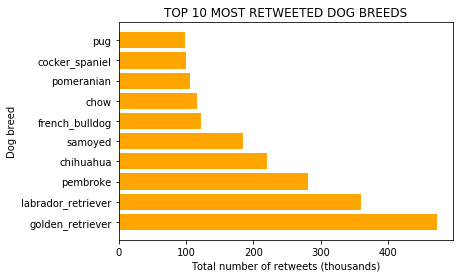

In [139]:
# creating the data
brlabels = ("TOP 10 MOST RETWEETED DOG BREEDS",
         "Total number of retweets (thousands)",
         "Dog breed")

# make a quick plot
quick_plot(labels=brlabels, dframe=df_brtfav, lbl_col='breed',
          val_col='total_retweets', kind='barh', ascend=False, qty=10)

#### Fig 1.1b Top ten most favorited dog breeds.

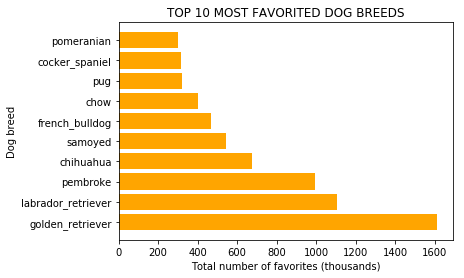

In [140]:
# creating the data
brlabels = ("TOP 10 MOST FAVORITED DOG BREEDS",
         "Total number of favorites (thousands)",
         "Dog breed")

# make a quick plot for favorites
quick_plot(labels=brlabels, dframe=df_brtfav, lbl_col='breed',
          val_col='total_favorites', kind='barh', ascend=False, qty=10)

In contrast, let's see the dog breeds with the least engagement.

In [141]:
# the least ten most retweeted, ascending order of retweets
df_brtfav.nsmallest(n=10, columns=['total_retweets'])

,breed,total_favorites,total_retweets
103,groenendael,1896,413
108,japanese_spaniel,1362,471
107,entlebucher,2678,706
102,appenzeller,2594,758
110,brabancon_griffon,2655,863
109,standard_schnauzer,2046,928
98,tibetan_terrier,4211,1150
105,scotch_terrier,3624,1250
106,ibizan_hound,3344,1293
93,welsh_springer_spaniel,8097,1551


In [142]:
# the least ten most favorited, ascending order of favorites
df_brtfav.nsmallest(n=10, columns=['total_favorites'])

,breed,total_favorites,total_retweets
108,japanese_spaniel,1362,471
103,groenendael,1896,413
109,standard_schnauzer,2046,928
102,appenzeller,2594,758
110,brabancon_griffon,2655,863
107,entlebucher,2678,706
106,ibizan_hound,3344,1293
105,scotch_terrier,3624,1250
98,tibetan_terrier,4211,1150
88,silky_terrier,7317,1891


There isn't much to say here other than I never even knew some of these existed. Perhaps that's one reason they're engaged with less frequently - because these are rarely-known dog breeds? More exploration is needed in that regard.

### Investigation #2: Relating dog stage and number of likes or retweets

My expectation is that puppers and puppos will generally get more likes and retweets. This is because they are generally perceived as 'cuter' and if [this](https://www.youtube.com/watch?v=Z0zConOPZ8Y) six-minute video is reliable evidence, humans are biased towards 'cute' things. So, let's see what we get.

As a precaution, not every dog-stage in the original dataset was specified so we'd only be working with a small subset of the original dataset. Still, let's have faith that it's a representative sample.

In [143]:
# create a useful sub dataframe
df_dogstage_rtfav = dfc_master[['dog_stage','retweet_count','favorite_count']]
df_dogstage_rtfav = df_dogstage_rtfav[df_dogstage_rtfav['dog_stage']!='N/A'].copy()
df_dogstage_rtfav.reset_index(inplace=True, drop=True)

In [144]:
# quick visual assessment
df_dogstage_rtfav['dog_stage'].value_counts()

pupper     155
doggo       49
puppo       25
floofer      6
Name: dog_stage, dtype: int64

It seems like there are a lot of puppers in this dataset.

In [145]:
# aggregate the retweets and faves
df_dgrtfav = uniques_rt_fav(column='dog_stage', dframe=df_dogstage_rtfav)

In [146]:
# sort by total retweets, descending order
df_dgrtfav.nlargest(n=4, columns=['total_retweets'])

,dog_stage,total_favorites,total_retweets
2,pupper,1266624,395269
0,doggo,1005744,368200
1,puppo,589759,172359
3,floofer,86366,32272


In [147]:
# sort by total favorites, descending order
df_dgrtfav.nlargest(n=4, columns=['total_favorites'])

,dog_stage,total_favorites,total_retweets
2,pupper,1266624,395269
0,doggo,1005744,368200
1,puppo,589759,172359
3,floofer,86366,32272


The results are clear. Puppers are the most engaged-with dog-stage in terms of either likes or retweets. Let's plot a quick barplot to make the relationship clearer.

#### Fig 2.1: Number of retweets for each dog-stage

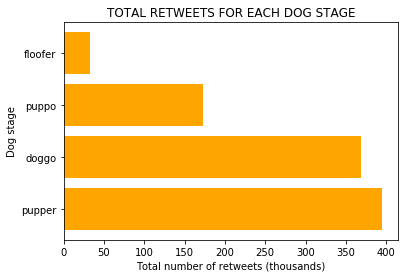

In [148]:
# creating the data
dslabels = ("TOTAL RETWEETS FOR EACH DOG STAGE",
         "Total number of retweets (thousands)",
         "Dog stage")

# make a quick plot for retweets
quick_plot(labels=dslabels, dframe=df_dgrtfav, lbl_col='dog_stage',
          val_col='total_retweets', kind='barh', ascend=False, qty=4)

#### Fig 2.2: Number of favorites for each dog-stage

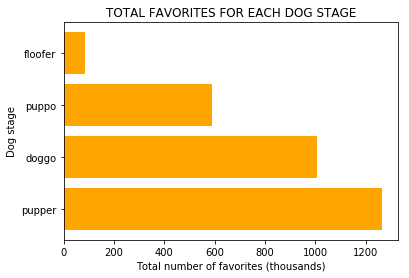

In [149]:
# creating the data
dslabels = ("TOTAL FAVORITES FOR EACH DOG STAGE",
         "Total number of favorites (thousands)",
         "Dog stage")

# make a quick plot for retweets
quick_plot(labels=dslabels, dframe=df_dgrtfav, lbl_col='dog_stage',
          val_col='total_favorites', kind='barh', ascend=False, qty=4)

### Investigation #3: Relating dog rating and number of likes or retweets

Even though the ratings are mostly humorous, let's see if there's any correlation between the rating and total number of likes or retweets.

In [150]:
# construct our dframe in one fell swoop
df_rate_rtfav = uniques_rt_fav(column='rating_numerator', dframe=dfc_master[['rating_numerator','retweet_count','favorite_count']])

In [151]:
# reorganise the dataframe a bit
df_rate_rtfav.rename(columns={'rating_numerator':'rating'},inplace=True)
df_rate_rtfav.sort_values(by='rating',inplace=True)
df_rate_rtfav.reset_index(inplace=True, drop=True)

In [152]:
# visually inspect the dataframe
df_rate_rtfav

,rating,total_favorites,total_retweets
0,2,5916,2880
1,3,9919,2814
2,4,10453,3633
3,5,69095,17369
4,6,17992,7624
5,7,51850,17808
6,8,114634,40963
7,9,259086,84574
8,10,1197618,426761
9,11,2004068,640915


However, for this information to be useful we have to deal with the average number of favorites and retweets for each column.

In [153]:
# convert to average by dividing total count by value_counts
for i in df_rate_rtfav.index:
    rting = df_rate_rtfav.at[i,'rating']
    counts = dfc_master['rating_numerator'].value_counts()[rting] # how many instances of rating?
    avg_favorites = df_rate_rtfav.at[i,'total_favorites']/counts
    df_rate_rtfav.at[i,'total_favorites'] = avg_favorites # reassign to the avg favorites
    avg_retweets = df_rate_rtfav.at[i,'total_retweets']/counts
    df_rate_rtfav.at[i,'total_retweets'] = avg_retweets

In [155]:
# rename the columns to reflect the change
df_rate_rtfav.rename(columns={'total_favorites':'average_favorites',
                              'total_retweets':'average_retweets'},
                    inplace=True)

In [156]:
# visually inspect
df_rate_rtfav

,rating,average_favorites,average_retweets
0,2,5916,2880
1,3,3306,938
2,4,2613,908
3,5,7677,1929
4,6,1999,847
5,7,2254,774
6,8,2047,731
7,9,2444,797
8,10,3814,1359
9,11,6592,2108


Surprisingly there seems to be a rough positive correlation between the rating and total favorites or retweets. The correlation is a bit janky, but it suggests that the ratings weren't completely jokes.

For good presentation, let's plot these in a graph.

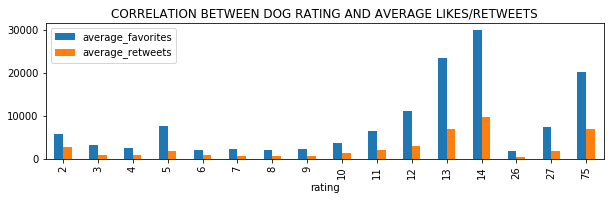

In [158]:
# plot the plot quickly
temp = df_rate_rtfav.set_index('rating')
temp.plot(title='correlation between dog rating and average likes/retweets'.upper(),
         figsize=(10,2.5),
         kind='bar') ;

### Insights:
1. Golden Retrievers are the most retweeted and favorited breed of dog in this dataset.

2. In contrast, the least retweeted/favorited are the Groenendael and Japanese Spaniel.

3. Puppers are likely the most retweeted and most favorited dog-stage.

4. The rating numerator roughly correlates with the total number of retweets or likes (favorites) for the dogs.

5. The number of likes (favorites) seems to be directly proportional to the number of retweets for any dog breed.

As a word of caution, we lost a lot of data points during our cleaning process and couldn't even obtain all missing values for dog-stage and name. However, it's reasonable to assume that the few values we could obtain (for dog-stage) are a representative sample.

Thus we conclude our data exploration.